# 1.

### 1.

Пусть событие $y$ - человек виновен, $X$ - кровь принадлежит редкой группе.

Прокурор совершает ошибку в том, что приравнивает условные вероятности: $$p(\neg y | X) = p(X | \neg y)$$

где $p(\neg y | X)$ - вероятность того, что человек невиновен при условии, что у него редкая группа крови,  

$p(X | \neg y)$ - вероятность того, что у человека редкая группа крови, если он невиновен.

И таким образом делает вывод, что человек виновен, при условии, что у него редкая группа крови: $$p(y | X) = 1 - p(\neg y | X) = 1 - p(X | \neg y) = 0.99$$

Для определения вероятности виновности человека, при условии наличия редкой группы крови нужно воспользоваться теоремой Байеса:

$$p(y | X) = \frac{p(X | y) p(y)}{p(X)}$$

### 2.

Адвокат сделал ошибку при вычислении условной вероятности $p(y|X)$, не учел второго слагаемого, отвечающего за виновного в знаменателе: $p(X) = p(X|\neg y)$, вместо $p(X) = p(X|\neg y)p(\neg y) + p(X|y)p(y)$.

Таким образом, адвокат посчитал вероятность:
$$p(y | X) = \frac{p(X | y) p(y)}{p(X|\neg y)}$$

Вместо следуемой:
$$p(y | X) = \frac{p(X | y) p(y)}{p(X|\neg y)p(\neg y) + p(X|y)p(y)}$$

### 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_fp(prior_prob=0.01, test_error=0.05):
    return test_error * (1 - prior_prob) / (( 1 - test_error) * prior_prob + test_error * (1 - prior_prob))

def compute_fn(prior_prob=0.01, test_error=0.05):
    return test_error * prior_prob / (test_error * prior_prob + (1 - test_error) * (1 - prior_prob))

In [3]:
vector_fp = np.vectorize(compute_fp, excluded=['test_error'])
vector_fn = np.vectorize(compute_fn, excluded=['test_error'])

xs = np.arange(0, 0.051, 0.001)
ys_fp = vector_fp(test_error=xs)
ys_fn = vector_fn(test_error=xs)

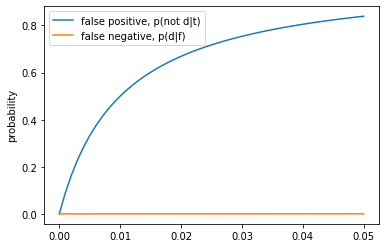

In [4]:
plt.plot(xs, ys_fp, label="false positive, p(not d|t)")
plt.plot(xs, ys_fn, label="false negative, p(d|f)")
plt.ylabel("probability")
plt.legend()


 Видно, что вероятность того, что человек не является больным при положительком тесте увеливается довольно сильно с увеличением ошибки теста. Таким образом, необходимо исключать false positive ошибки.

# 2.

In [5]:
import pandas as pd
from sklearn import linear_model
from scipy.stats import multivariate_normal
import seaborn as sns
import scipy.integrate as integrate


legend_fontsize = 16



palette = sns.color_palette()

In [6]:
df = pd.read_csv("owid-covid-data.csv")

In [7]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [8]:
df_rus = df[df['iso_code'] == 'RUS'].copy()

In [9]:
df_rus = df_rus[df_rus['date'] >= '2020-03-03'].copy()

In [10]:
total_cases = df_rus['total_cases']
new_cases = df_rus['new_cases']

In [11]:
new_cases[new_cases==0] = 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
x = np.arange(0, 50)

total_cases_train = df_rus['total_cases'][:50]
total_cases_test = df_rus['total_cases'][50:]

new_cases_train = df_rus['new_cases'][:50]
new_cases_test = df_rus['new_cases'][50:]

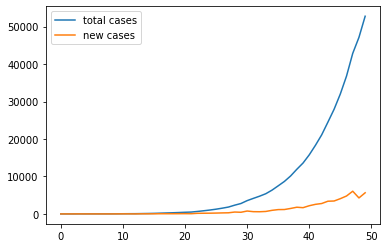

In [13]:
plt.plot(x, total_cases_train, label = "total cases")
plt.plot(x, new_cases_train, label = "new cases")
plt.legend()

In [14]:
X_train = x.copy()
y_total_train = np.array(np.log(total_cases_train))
y_new_train = np.array(np.log(new_cases_train))

# Exp

In [15]:
model = linear_model.LinearRegression().fit(X_train[:, np.newaxis], y_total_train)

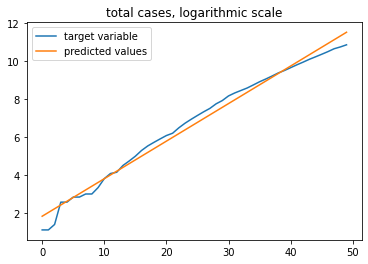

In [16]:
plt.title("total cases, logarithmic scale")
plt.plot(X_train, y_total_train, label = "target variable")
plt.plot(X_train, model.coef_ * X_train + model.intercept_, label = "predicted values")
plt.legend()

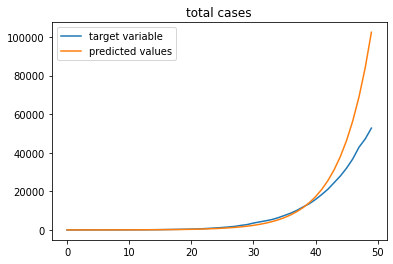

In [17]:
plt.title("total cases")
plt.plot(X_train, total_cases_train, label = "target variable")
plt.plot(X_train, np.exp(model.coef_ * X_train + model.intercept_), label = "predicted values")
plt.legend()

In [18]:
print("Model coefficients: ", model.coef_[0], ",", model.intercept_)

Model coefficients:  0.19829091233588567 , 1.820737148784695


In [19]:
mu = np.array([model.intercept_, model.coef_[0]])
sigma_noise = (np.sum((np.log(total_cases_train) - (mu[0] + mu[1] * X_train)) ** 2) / 50) ** 0.5

In [20]:
print("Value of sigma noise: ", sigma_noise)

Value of sigma noise:  0.34904220596356583


In [21]:
cur_mu, cur_cov = np.array([0, 0]), 2 * np.array([[1, 0], [0, 1]])

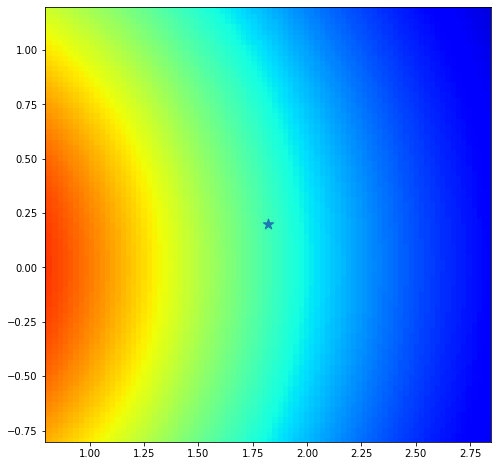

In [22]:
def myplot_heatmap(Z):
    plt.axis('equal')
    plt.xlim((mu[0] - 1, mu[0] + 1))
    plt.ylim((mu[1] - 1, mu[1] + 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(mu[0], mu[1], marker='*', s=120)

N = 250
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_cov)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

In [23]:
def myplot_sample_lines(mu, cov, xs, n=20):
    plt.xlim((xs[0], xs[-1]))
    my_w = np.random.multivariate_normal(mu, cov, n)
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)

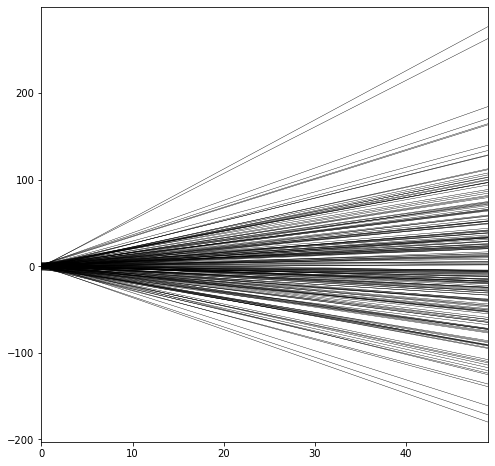

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((X_train[0], X_train[-1]))
myplot_sample_lines(cur_mu, cur_cov, X_train, 200)

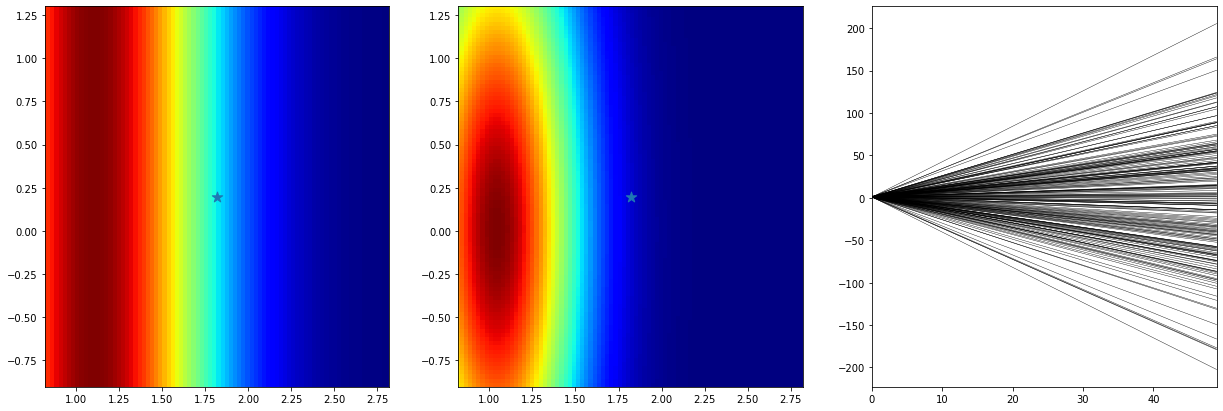

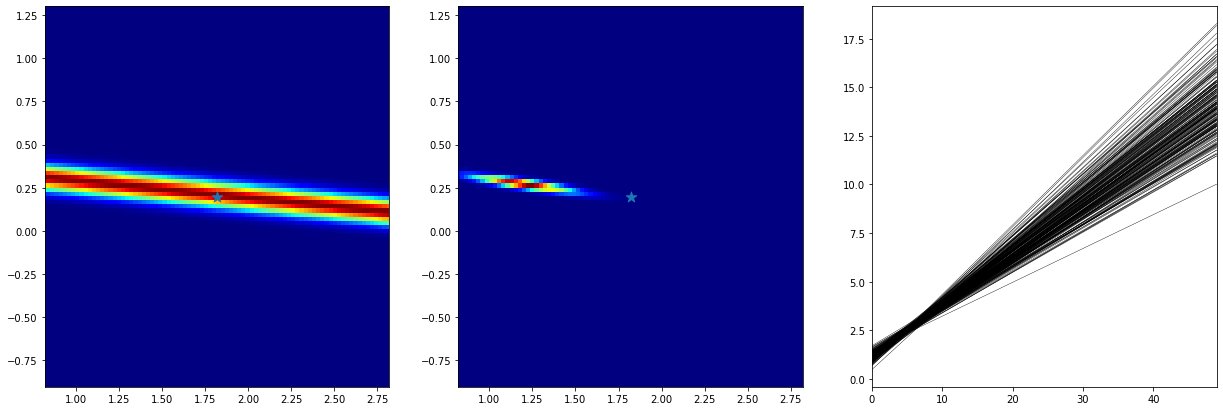

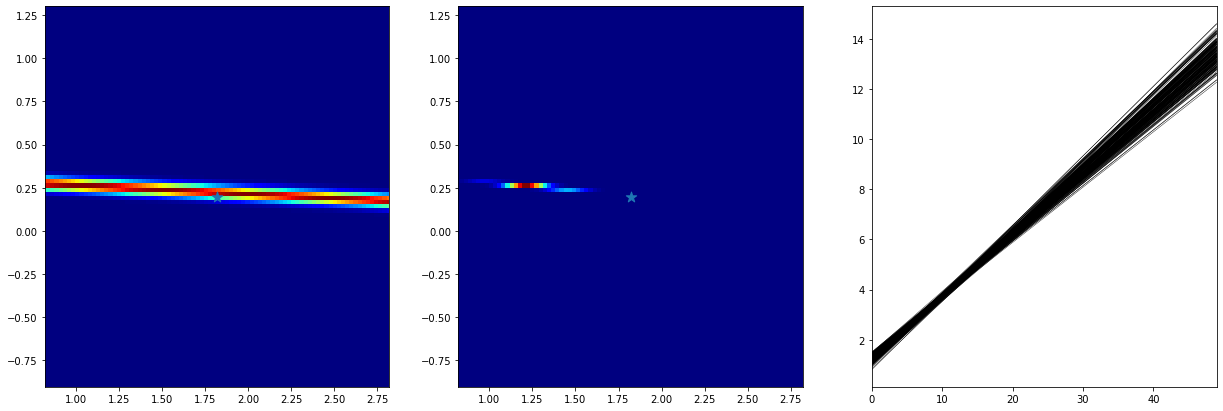

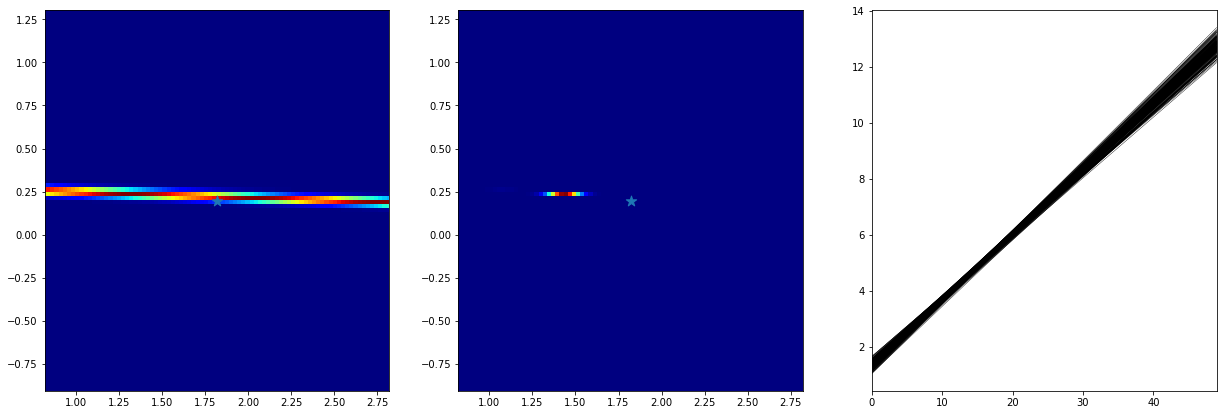

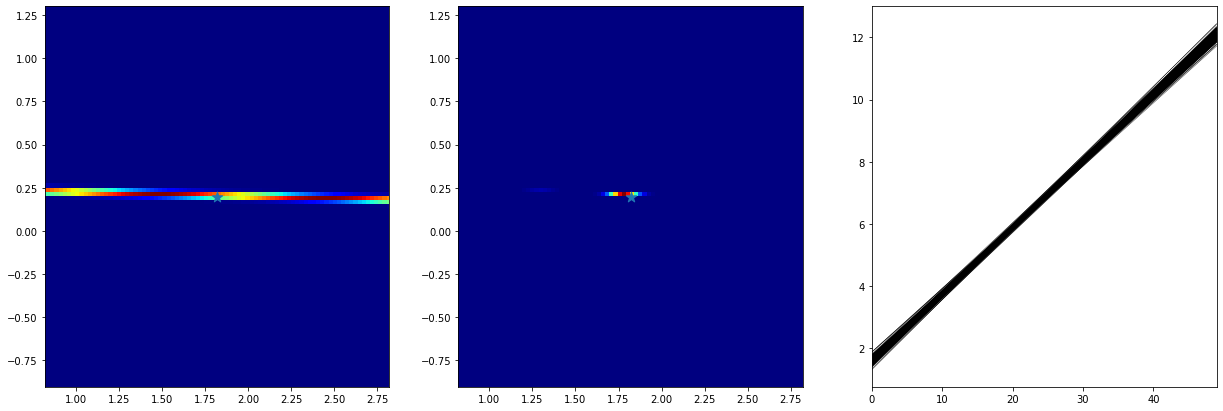

In [25]:
def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp((-(x[0] + x[1]*px - py) ** 2)/(2 * sigma ** 2)) / (2 * sigma * np.sqrt(2.*np.pi))

def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

for i in range(len(X_train)):
    px, py = X_train[i], y_total_train[i]
    cur_likelihood = get_likelihood(px, py)
    Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
    if i % 10 == 0:
        plt.figure(figsize=(21,7))
        plt.subplot(1,3,1)
        myplot_heatmap(Z)

    cur_mu, cur_cov = bayesian_update(cur_mu, cur_cov, px, py)
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_cov)
    if i % 10 == 0:
        plt.subplot(1,3,2)
        myplot_heatmap(Z)
    if i % 10 == 0:
        plt.subplot(1,3,3)
        myplot_sample_lines(cur_mu, cur_cov, X_train, 200)
    plt.show()

In [26]:
def sample_statistics_log_scale(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

def plot_predictions_log_scale(xs, mu, x, y_train):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_title("Log масштаб", fontsize=legend_fontsize+2)
    ax.plot(xs, np.array(y_train), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - sigma_noise, mu[1]*xs + mu[0] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

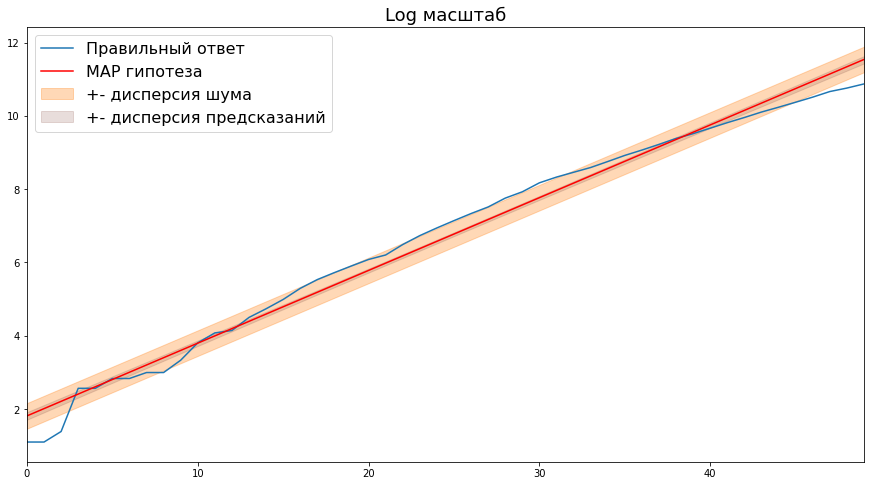

In [27]:
ys = sample_statistics_log_scale(cur_mu, cur_cov, X_train, n=200)
plot_predictions_log_scale(X_train, cur_mu, ys, y_total_train)

In [28]:
def sample_statistics_exp(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

def plot_predictions_exp(xs, mu, x, y_train):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, np.exp(y_train), label="Правильный ответ")
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - sigma_noise), np.exp(mu[1]*xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, (np.mean(x, axis=0) - np.std(x, axis=0)), (np.mean(x, axis=0) + np.std(x, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

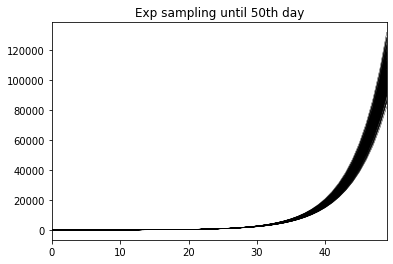

In [29]:
def myplot_sample_exp(mu, cov, xs, n=20):
    plt.xlim((xs[0], xs[-1]))
    my_w = np.random.multivariate_normal(mu, cov, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
ys = sample_statistics_exp(cur_mu, cur_cov, X_train, n=200)
plt.title("Exp sampling until 50th day")


myplot_sample_exp(cur_mu, cur_cov, X_train, 200)

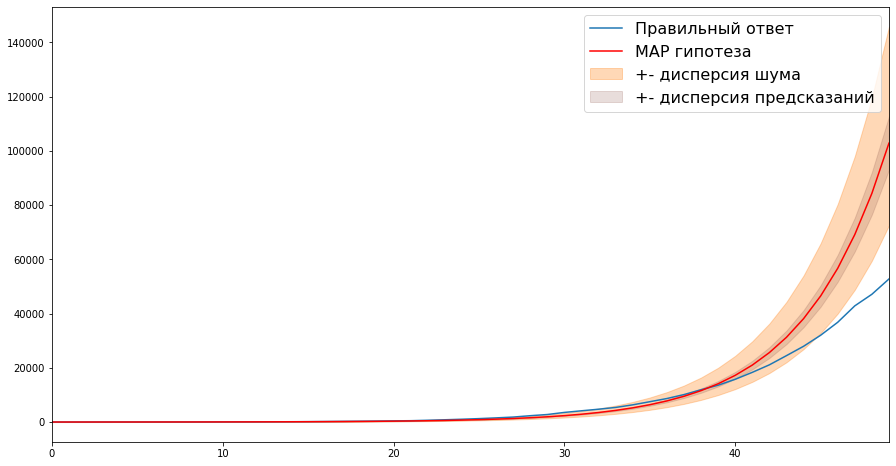

In [30]:
plot_predictions_exp(X_train, cur_mu, ys, y_total_train)

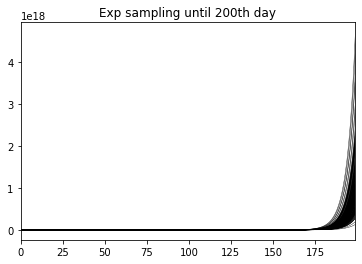

In [31]:
xs = np.arange(0, 200, 1)
ys = sample_statistics_exp(cur_mu, cur_cov, xs, n=200)
plt.title("Exp sampling until 200th day")
myplot_sample_exp(cur_mu, cur_cov, xs, 200)

In [32]:
def plot_predictions_exp_(xs, mu, x):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - sigma_noise), np.exp(mu[1]*xs + mu[0] + sigma_noise), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, (np.mean(x, axis=0) - np.std(x, axis=0)), (np.mean(x, axis=0) + np.std(x, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

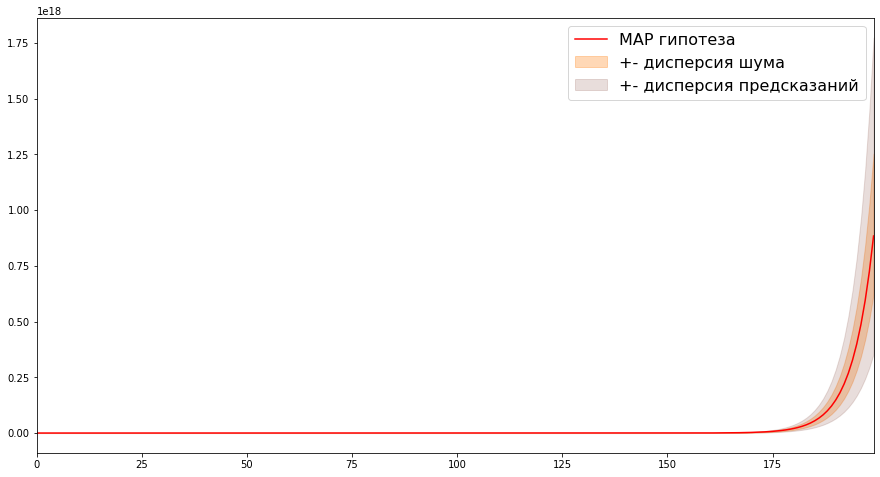

In [33]:
plot_predictions_exp_(xs, cur_mu, ys)

In [34]:
print("К 1 мая количество заболевших будет: ", np.mean(ys[:, 58]), "+-", np.std(ys[:, 58]))

К 1 мая количество заболевших будет:  616829.2648031703 +- 76702.06968183121


In [35]:
print("К 1 июня количество заболевших будет: ", np.mean(ys[:, 89]), "+-", np.std(ys[:, 89]))

К 1 июня количество заболевших будет:  296337148.1572108 +- 67560309.77321354


In [36]:
print("К 1 сентября количество заболевших будет: ", np.mean(ys[:, 181]) / 10 ** 16, "10 ** 16", "+-", np.std(ys[:, 181]) /  10 ** 16, "10 ** 16")

К 1 сентября количество заболевших будет:  2.8788460095713475 10 ** 16 +- 1.6830353138329033 10 ** 16


# Sigmoid

In [37]:
X_train = np.arange(0, 50)

In [38]:
X_train_d = np.vstack([X_train ** i for i in range(1, 3)]).transpose()

In [39]:
y_grad = np.array(new_cases_train)

In [40]:
y_total_train = np.log(y_grad.copy())

In [41]:
model = linear_model.LinearRegression().fit(X_train_d[:, :2], y_total_train)

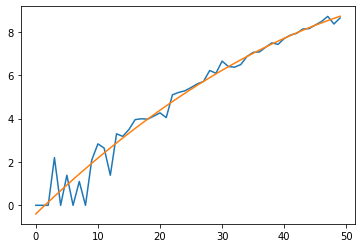

In [42]:
plt.plot(X_train, y_total_train)
plt.plot(X_train, model.predict( X_train_d[:, :2] ))

In [43]:
mu = np.array([model.intercept_, model.coef_[0], model.coef_[1]])

In [44]:
sigma_noise = (np.sum((y_total_train - (mu[0] + mu[1] * X_train_d[:, 0] + mu[2] * X_train_d[:, 1])) ** 2) / 50) ** 0.5

In [45]:
cur_mu, cur_cov = np.array([0, 0, 0]), 2 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [46]:
def myplot_sample_lines(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    for w in my_w:
        plt.plot(xs[:,0], w[0] + w[1] * xs[:, 0] + w[2] * xs[:, 1], 'k-', lw=.4)

In [47]:
N = 50
X_1 = np.linspace(-3, 3, N)
X_2 = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X_1, X_2, Y = np.meshgrid(X_1, X_2, Y)

pos = np.empty(X_1.shape + (3,))
pos[:, :, :, 0] = X_1
pos[:, :, :, 1] = X_2
pos[:, :, :, 2] = Y
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_cov)

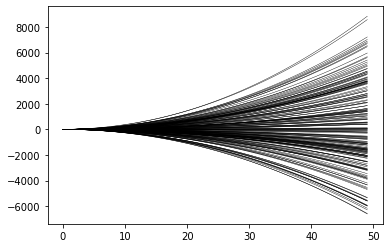

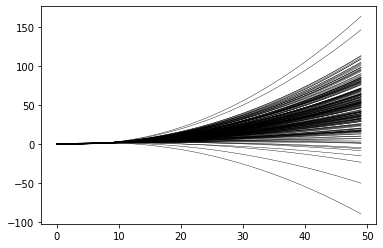

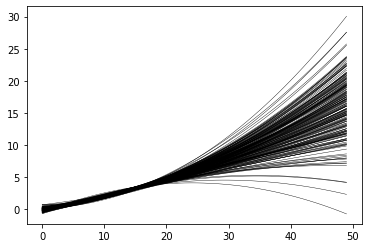

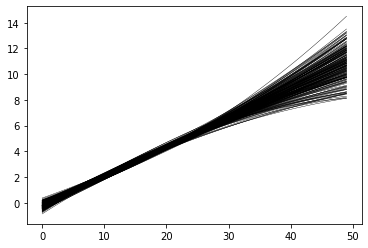

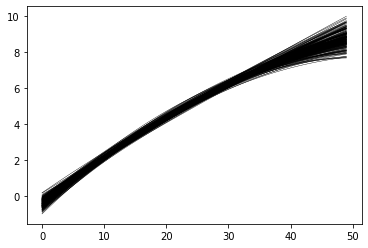

In [48]:
def get_likelihood(px_1, px_2, py, sigma=.5):
    return lambda x : np.exp((-(x[0] + x[1] * px_1 + x[2] * px_2 - py) ** 2)/(2 * sigma ** 2)) / (2 * sigma * np.sqrt(2.*np.pi))

def bayesian_update(mu, sigma, x_1, x_2, y, sigma_noise=sigma_noise):
    x_matrix = np.array([[1, x_1, x_2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

for i in range(X_train_d.shape[0]):
    px_1, px_2, py = X_train_d[i][0], X_train_d[i][1], y_total_train[i]
    cur_likelihood = get_likelihood(px_1, px_2, py)
    Z = np.array([[[ cur_likelihood(pos[i, j, k]) for k in range(pos.shape[2])] for j in range(pos.shape[1])] for i in range(pos.shape[0])])

    cur_mu, cur_cov = bayesian_update(cur_mu, cur_cov, px_1, px_2, py)
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_cov)
    if i % 10 == 0:
        myplot_sample_lines(cur_mu, cur_cov, X_train_d, 200)
    plt.show()

In [118]:
def sample_statistics_log_scale(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1] * xs[:, 0] + w[2] * xs[:, 1]
    return res

def plot_predictions_log_scale(xs, mu, x, points):
    dim = 50
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[:, 0][0], xs[:, 0][-1]))
    ax.plot(xs[:, 0], np.log(np.array(new_cases))[:dim], label="Правильный ответ")
    ax.plot(xs[:, 0], mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1], color="red", label="MAP гипотеза")
    ax.fill_between(xs[:, 0], mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1] - sigma_noise, mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1] + sigma_noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs[:, 0], np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

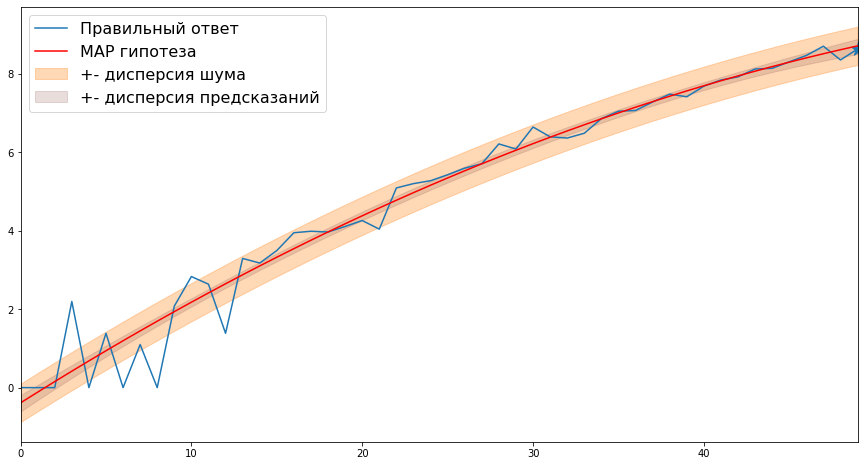

In [119]:
dim = 50
xs = np.arange(0, dim, 1)
X_train = np.arange(0, dim, 1)
X_train_d = np.vstack([X_train ** i for i in range(1, 3)]).transpose()
ys = sample_statistics_log_scale(cur_mu, cur_cov, X_train_d, n=200)
plot_predictions_log_scale(X_train_d, cur_mu, ys, [[px], [py]])

In [121]:
def sample_statistics_exp(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1] * xs[:, 0] + w[2] * xs[:, 1])
    return res

def plot_predictions_exp(xs, mu, x):
    dim = 50
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[:, 0][0], xs[:, 0][-1]))
    y_grad = np.gradient(np.array(total_cases)[:dim])
    ax.plot(xs[:, 0], y_grad, label="Правильный ответ")
    ax.plot(xs[:, 0], np.exp(mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1])[:dim], color="red", label="MAP гипотеза")
    ax.fill_between(xs[:, 0], np.exp(mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1] - sigma_noise)[:dim], np.exp(mu[0] + mu[1] * xs[:, 0] + mu[2] * xs[:, 1] + sigma_noise)[:dim], color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs[:, 0], (np.mean(x, axis=0) - np.std(x, axis=0))[:dim], (np.mean(x, axis=0) + np.std(x, axis=0))[:dim], color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)
    
def myplot_sample_exp(mu, cov, xs, n=20):
    plt.xlim((xs[:, 0][0], xs[:, 0][-1]))
    my_w = np.random.multivariate_normal(mu, cov, n)
    for w in my_w:
        plt.plot(xs[:, 0], np.exp(w[0] + w[1] * xs[:, 0] + w[2] * xs[:, 1]), 'k-', lw=.4)

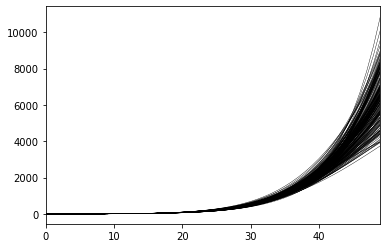

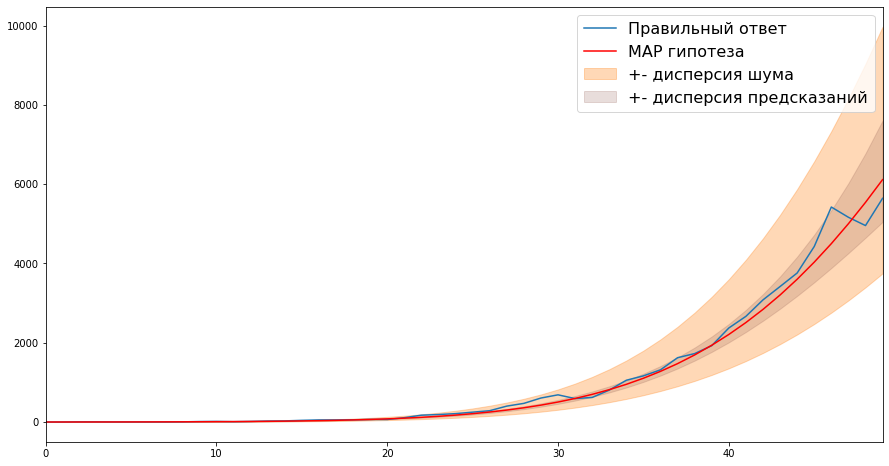

In [122]:
dim = 50
xs = np.arange(0, dim, 1)
X_train = np.arange(0, dim, 1)
X_train_d = np.vstack([X_train ** i for i in range(1, 3)]).transpose()
ys = sample_statistics_exp(cur_mu, cur_cov, X_train_d, n=200)
myplot_sample_exp(cur_mu, cur_cov, X_train_d, 200)
plot_predictions_exp(X_train_d, cur_mu, ys)

In [155]:
def plot_predictions_sigmoid(xs, mu, ys, dim):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[:, 0][0], xs[:, 0][-1]))
    ax.set_ylim((-2, 2e6))
    ax.plot(xs[:, 0], np.array(total_cases)[:dim], label="Правильный ответ")
    res = [np.sum([np.exp(mu[0] + mu[1] * x + mu[2] * (x ** 2)) for x in xs[:, 0]][:i + 1]) for i in range(xs.shape[0])]
    ax.plot(xs[:, 0], res, color="red", label="MAP гипотеза")
    res_noise_1 = [np.sum([np.exp(mu[0] + mu[1] * x + mu[2] * (x ** 2) - sigma_noise) for x in xs[:, 0]][:i + 1]) for i in range(xs.shape[0])]
    res_noise_2 = [np.sum([np.exp(mu[0] + mu[1] * x + mu[2] * (x ** 2) + sigma_noise) for x in xs[:, 0]][:i + 1]) for i in range(xs.shape[0])]
    
    ax.fill_between(xs[:, 0], res_noise_1, res_noise_2, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs[:, 0], (np.mean(ys, axis=0) - np.std(ys, axis=0)), (np.mean(ys, axis=0) + np.std(ys, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

In [156]:
def myplot_sample_sigmoid(mu, cov, xs, n=20):
    plt.xlim((xs[:, 0][0], xs[:, 0][-1]))
    my_w = np.random.multivariate_normal(mu, cov, n)
    for w in my_w:
        res = [np.sum([np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in xs[:, 0]][:i + 1]) for i in range(xs.shape[0])]
        plt.plot(xs[:, 0], res, 'k-', lw=.4)
    #plt.show()
    #for w in my_w:
    #    plt.plot(xs[:, 0], np.exp(w[0] + w[1] * xs[:, 0] + w[2] * xs[:, 1]))
    #plt.show()

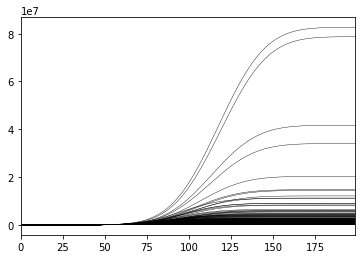

In [157]:
dim = 200
X_train = np.arange(0, dim, 1)
X_train_d = np.vstack([X_train ** i for i in range(1, 3)]).transpose()
myplot_sample_sigmoid(cur_mu, cur_cov, X_train_d, 200)

In [158]:
def sample_statistics_sigmoid(mu, cov, xs, n=20):
    my_w = np.random.multivariate_normal(mu, cov, n)
    res = np.zeros((n, xs.shape[0]))
    for i, w in enumerate(my_w):
        res[i,:] = [np.sum([np.exp(w[0] + w[1] * x + w[2] * (x ** 2)) for x in xs[:, 0]][:j + 1]) for j in range(xs.shape[0])]
    return res

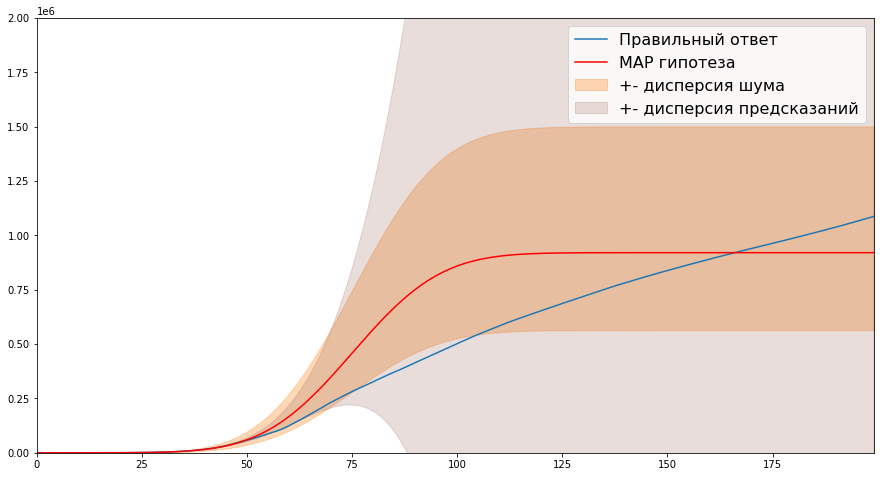

In [159]:
dim = 200
X_train = np.arange(0, dim, 1)
X_train_d = np.vstack([X_train ** i for i in range(1, 3)]).transpose()
ys = sample_statistics_sigmoid(cur_mu, cur_cov, X_train_d, n=200)
plot_predictions_sigmoid(X_train_d, cur_mu, ys, dim)

In [58]:
print("Количество заболевших будет: ", ys[:, -1].mean(), "+-", np.std(ys[:, -1]))

Количество заболевших будет:  4785590.307908041 +- 21582021.265347533


In [59]:
print("10 процентиль: ", np.percentile(ys[:, -1], 10))

10 процентиль:  307373.03820222785


In [60]:
print("90 процентиль: ", np.percentile(ys[:, -1], 90))

90 процентиль:  7407886.12777896
